In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.decomposition import TruncatedSVD
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score, roc_auc_score,
                             roc_curve, auc)
import joblib
import warnings
from google.colab import files
warnings.filterwarnings('ignore')

%matplotlib inline

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("="*80)
print("ADVANCED ML PIPELINE - KERNEL APPROXIMATION, SVC, GRADIENT BOOSTING")
print("="*80)


ADVANCED ML PIPELINE - KERNEL APPROXIMATION, SVC, GRADIENT BOOSTING


# # 1. Load Train, Validation, and Test Data


In [2]:
print("\n" + "="*80)
print("LOADING DATA")
print("="*80)

uploaded = files.upload()

# Load the split datasets
train_data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('validation_data.csv')
test_data = pd.read_csv('test_data.csv')

print(f"✓ Training data loaded: {train_data.shape}")
print(f"✓ Validation data loaded: {val_data.shape}")
print(f"✓ Test data loaded: {test_data.shape}")

print("\nTraining data preview:")
print(train_data.head())

print("\nData info:")
print(train_data.info())



LOADING DATA


Saving test_data.csv to test_data.csv
Saving train_data.csv to train_data.csv
Saving validation_data.csv to validation_data.csv
✓ Training data loaded: (350000, 11)
✓ Validation data loaded: (49995, 11)
✓ Test data loaded: (100005, 11)

Training data preview:
                    timestamp       source_ip      server       username  \
0  2024-04-20T10:27:49.844969    26.128.29.98  srv-tok-03    amberflores   
1  2023-12-20T19:33:50.527558    28.235.0.176  srv-tok-03       robert29   
2  2023-01-31T06:10:43.916550   216.94.236.83  srv-tok-03          nginx   
3  2025-02-05T22:26:26.039715  169.244.141.16  web-sgp-02  victoriajones   
4  2024-09-08T12:37:07.607083   105.210.69.35  web-sgp-02        james36   

  service  attempts   status  port protocol  \
0   login         2   Failed    80      RDP   
1    cron         1  Success    22     SSH2   
2     ssh         1  Success    22     SSH2   
3    cron         5   Failed    80   TELNET   
4    sudo         2   Failed   443     SSH2   



# # 2. Advanced Feature Engineering


In [ ]:
print("\n" + "="*80)
print("ADVANCED FEATURE ENGINEERING")
print("="*80)

def advanced_feature_engineering(df):
    """
    Apply advanced feature engineering
    Focus on: Aggregations, Interactions, Statistical features
    """
    df_engineered = df.copy()

    # Convert timestamp to datetime
    if 'timestamp' in df_engineered.columns:
        df_engineered['timestamp'] = pd.to_datetime(df_engineered['timestamp'])

        # Different time-based features 
        df_engineered['hour'] = df_engineered['timestamp'].dt.hour
        df_engineered['day_of_week'] = df_engineered['timestamp'].dt.dayofweek
        df_engineered['is_business_hours'] = ((df_engineered['hour'] >= 9) & (df_engineered['hour'] <= 17)).astype(int)
        df_engineered['is_midnight_to_6am'] = ((df_engineered['hour'] >= 0) & (df_engineered['hour'] <= 6)).astype(int)
        df_engineered['hour_sin'] = np.sin(2 * np.pi * df_engineered['hour'] / 24)
        df_engineered['hour_cos'] = np.cos(2 * np.pi * df_engineered['hour'] / 24)
        df_engineered['day_sin'] = np.sin(2 * np.pi * df_engineered['day_of_week'] / 7)
        df_engineered['day_cos'] = np.cos(2 * np.pi * df_engineered['day_of_week'] / 7)

        # Drop original timestamp
        df_engineered = df_engineered.drop('timestamp', axis=1)

    # Feature interactions 
    if 'attempts' in df_engineered.columns and 'port' in df_engineered.columns:
        df_engineered['attempts_x_port'] = df_engineered['attempts'] * df_engineered['port']
        df_engineered['attempts_squared'] = df_engineered['attempts'] ** 2
        df_engineered['port_log'] = np.log1p(df_engineered['port'])

    # Statistical features for attempts
    if 'attempts' in df_engineered.columns:
        df_engineered['attempts_high'] = (df_engineered['attempts'] > 3).astype(int)
        df_engineered['attempts_very_high'] = (df_engineered['attempts'] > 5).astype(int)

    # Port categorization 
    if 'port' in df_engineered.columns:
        df_engineered['is_common_port'] = df_engineered['port'].isin([22, 80, 443, 3389]).astype(int)
        df_engineered['is_ssh_port'] = (df_engineered['port'] == 22).astype(int)
        df_engineered['is_http_port'] = (df_engineered['port'].isin([80, 443])).astype(int)

    # Handle categorical variables with Ordinal Encoding 
    categorical_cols = df_engineered.select_dtypes(include=['object']).columns.tolist()

    # Remove target if present
    if 'anomaly_label' in categorical_cols:
        categorical_cols.remove('anomaly_label')

    # Remove comment if exists (too many unique values)
    if 'comment' in categorical_cols:
        categorical_cols.remove('comment')
        df_engineered = df_engineered.drop('comment', axis=1)

    # Ordinal encoding
    ordinal_encoders = {}
    for col in categorical_cols:
        # Create frequency-based encoding (encode by frequency)
        freq_encoding = df_engineered[col].value_counts().to_dict()
        df_engineered[f'{col}_freq'] = df_engineered[col].map(freq_encoding)

        # Ordinal encoding
        oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        df_engineered[col] = oe.fit_transform(df_engineered[[col]])
        ordinal_encoders[col] = oe

    return df_engineered, ordinal_encoders

# Apply advanced feature engineering
print("Applying advanced feature engineering...")
train_engineered, encoders = advanced_feature_engineering(train_data)
val_engineered, _ = advanced_feature_engineering(val_data)
test_engineered, _ = advanced_feature_engineering(test_data)

print(f"\n✓ Training data after engineering: {train_engineered.shape}")
print(f"✓ Validation data after engineering: {val_engineered.shape}")
print(f"✓ Test data after engineering: {test_engineered.shape}")

print("\nNew engineered features:")
new_features = [col for col in train_engineered.columns if col not in train_data.columns or col == 'anomaly_label']
print(new_features)



ADVANCED FEATURE ENGINEERING
Applying advanced feature engineering...

✓ Training data after engineering: (350000, 31)
✓ Validation data after engineering: (49995, 31)
✓ Test data after engineering: (100005, 31)

New engineered features:
['anomaly_label', 'hour', 'day_of_week', 'is_business_hours', 'is_midnight_to_6am', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'attempts_x_port', 'attempts_squared', 'port_log', 'attempts_high', 'attempts_very_high', 'is_common_port', 'is_ssh_port', 'is_http_port', 'source_ip_freq', 'server_freq', 'username_freq', 'service_freq', 'status_freq', 'protocol_freq']


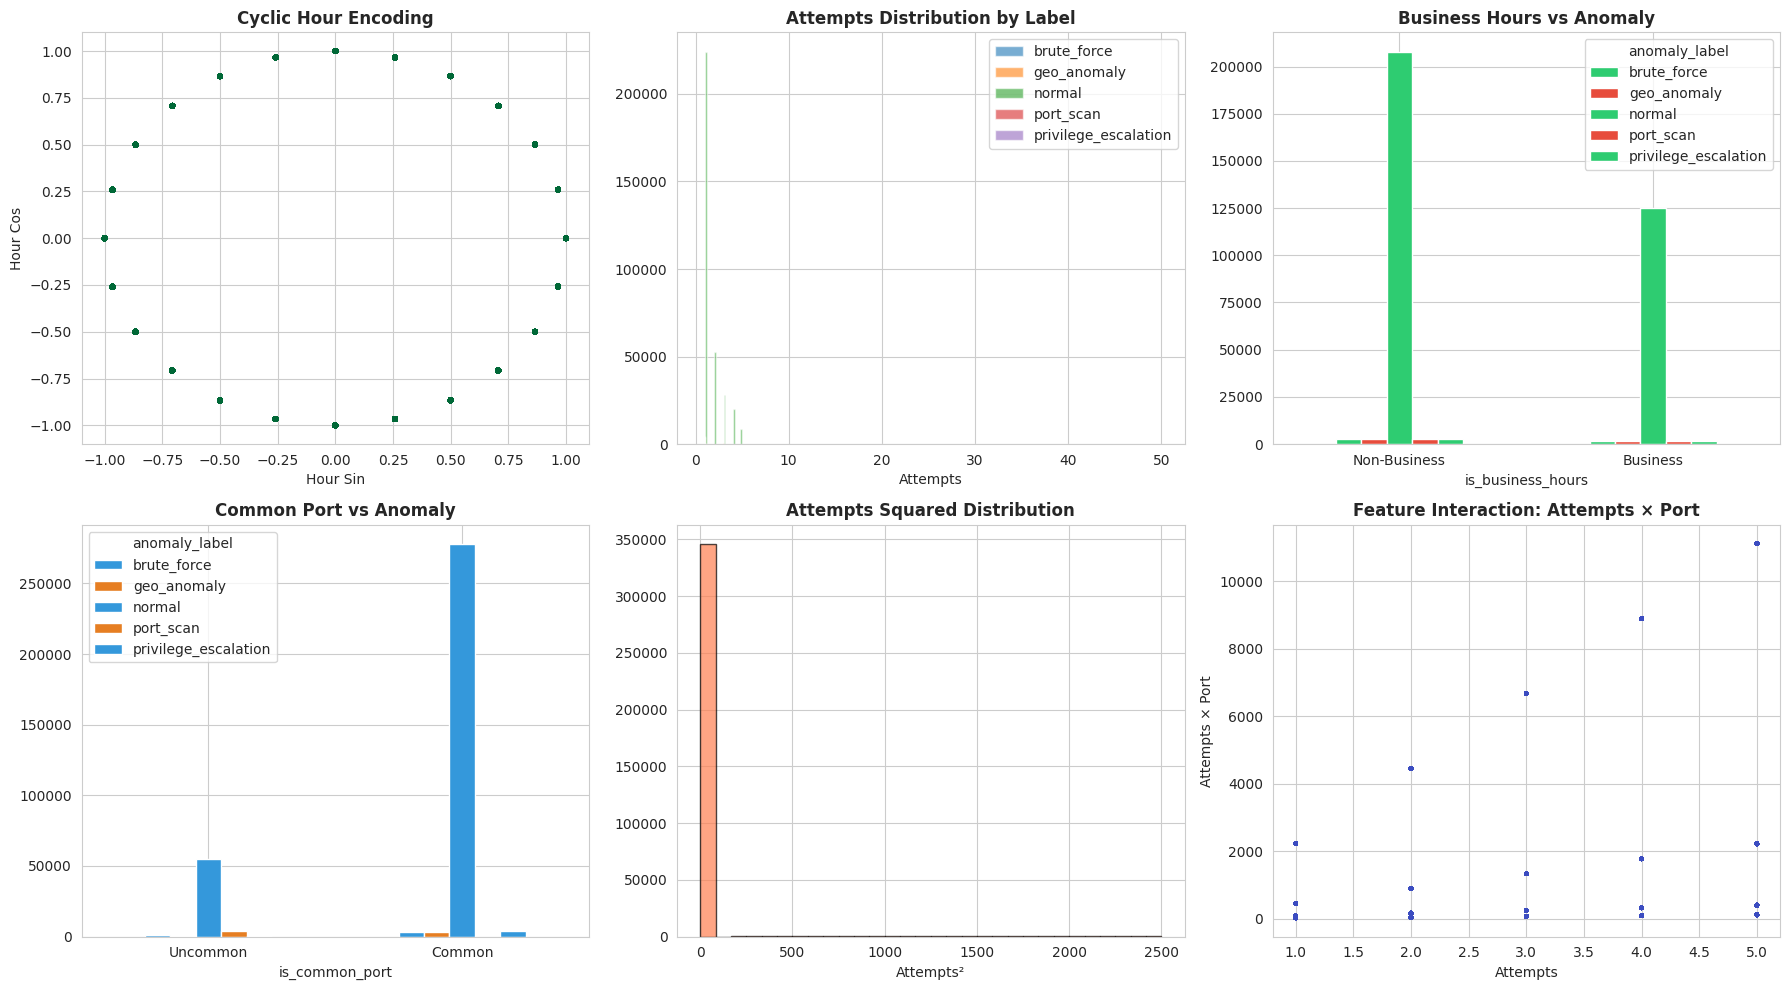

In [4]:
# Visualize new features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Hour sin/cos
if 'hour_sin' in train_engineered.columns:
    axes[0, 0].scatter(train_engineered['hour_sin'], train_engineered['hour_cos'],
                       c=train_engineered['anomaly_label'].map({'normal': 0, 'anomaly': 1}),
                       cmap='RdYlGn_r', alpha=0.5, s=10)
    axes[0, 0].set_title('Cyclic Hour Encoding', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Hour Sin')
    axes[0, 0].set_ylabel('Hour Cos')

# Plot 2: Attempts distribution
if 'attempts' in train_engineered.columns:
    train_engineered.groupby('anomaly_label')['attempts'].hist(ax=axes[0, 1], alpha=0.6, bins=20, legend=True)
    axes[0, 1].set_title('Attempts Distribution by Label', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Attempts')

# Plot 3: Business hours vs anomaly
if 'is_business_hours' in train_engineered.columns:
    pd.crosstab(train_engineered['is_business_hours'], train_engineered['anomaly_label']).plot(
        kind='bar', ax=axes[0, 2], color=['#2ecc71', '#e74c3c'])
    axes[0, 2].set_title('Business Hours vs Anomaly', fontsize=12, fontweight='bold')
    axes[0, 2].set_xticklabels(['Non-Business', 'Business'], rotation=0)

# Plot 4: Common port vs anomaly
if 'is_common_port' in train_engineered.columns:
    pd.crosstab(train_engineered['is_common_port'], train_engineered['anomaly_label']).plot(
        kind='bar', ax=axes[1, 0], color=['#3498db', '#e67e22'])
    axes[1, 0].set_title('Common Port vs Anomaly', fontsize=12, fontweight='bold')
    axes[1, 0].set_xticklabels(['Uncommon', 'Common'], rotation=0)

# Plot 5: Attempts squared distribution
if 'attempts_squared' in train_engineered.columns:
    axes[1, 1].hist(train_engineered['attempts_squared'], bins=30, color='coral', alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Attempts Squared Distribution', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Attempts²')

# Plot 6: Feature interaction
if 'attempts_x_port' in train_engineered.columns:
    axes[1, 2].scatter(train_engineered['attempts'], train_engineered['attempts_x_port'],
                       c=train_engineered['anomaly_label'].map({'normal': 0, 'anomaly': 1}),
                       cmap='coolwarm', alpha=0.3, s=5)
    axes[1, 2].set_title('Feature Interaction: Attempts × Port', fontsize=12, fontweight='bold')
    axes[1, 2].set_xlabel('Attempts')
    axes[1, 2].set_ylabel('Attempts × Port')

plt.tight_layout()
plt.show()


In [5]:
# Separate features and target
print("\n" + "="*80)
print("SEPARATING FEATURES AND TARGET")
print("="*80)

# Encode target variable
from sklearn.preprocessing import LabelEncoder
le_target = LabelEncoder()
y_train = le_target.fit_transform(train_engineered['anomaly_label'])
y_val = le_target.transform(val_engineered['anomaly_label'])
y_test = le_target.transform(test_engineered['anomaly_label'])

# Drop target from features
X_train = train_engineered.drop('anomaly_label', axis=1)
X_val = val_engineered.drop('anomaly_label', axis=1)
X_test = test_engineered.drop('anomaly_label', axis=1)

print(f"✓ X_train shape: {X_train.shape}")
print(f"✓ X_val shape: {X_val.shape}")
print(f"✓ X_test shape: {X_test.shape}")
print(f"\nTarget classes: {le_target.classes_}")
print(f"Train class distribution: {np.bincount(y_train)}")



SEPARATING FEATURES AND TARGET
✓ X_train shape: (350000, 30)
✓ X_val shape: (49995, 30)
✓ X_test shape: (100005, 30)

Target classes: ['brute_force' 'geo_anomaly' 'normal' 'port_scan' 'privilege_escalation']
Train class distribution: [  4363   4290 332705   4287   4355]


# # 3. Feature Scaling with RobustScaler


In [6]:
print("\n" + "="*80)
print("FEATURE SCALING - ROBUST SCALER")
print("="*80)

# RobustScaler is less sensitive to outliers than StandardScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled using RobustScaler (median-based, robust to outliers)")
print(f"✓ Scaled train data shape: {X_train_scaled.shape}")

# Save scaler
joblib.dump(scaler, 'robust_scaler.pkl')
print("✓ Scaler saved as 'robust_scaler.pkl'")



FEATURE SCALING - ROBUST SCALER
✓ Features scaled using RobustScaler (median-based, robust to outliers)
✓ Scaled train data shape: (350000, 30)
✓ Scaler saved as 'robust_scaler.pkl'


# # 4. Feature Selection with RFE


In [7]:
print("\n" + "="*80)
print("FEATURE SELECTION - RECURSIVE FEATURE ELIMINATION (RFE)")
print("="*80)

# Use Logistic Regression as estimator for RFE
# RFE recursively removes features and builds model on remaining attributes
estimator = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
n_features_to_select = max(15, int(0.7 * X_train_scaled.shape[1]))  # Keep 70% or at least 15

selector = RFE(estimator=estimator, n_features_to_select=n_features_to_select, step=1)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

print(f"✓ RFE with Logistic Regression")
print(f"✓ Original features: {X_train_scaled.shape[1]}")
print(f"✓ Selected features: {X_train_selected.shape[1]}")

# Get selected feature names
selected_features = X_train.columns[selector.support_].tolist()
print(f"\nSelected features ({len(selected_features)}):")
for i, feat in enumerate(selected_features[:10], 1):
    print(f"  {i}. {feat}")
if len(selected_features) > 10:
    print(f"  ... and {len(selected_features) - 10} more")

# Save selector
joblib.dump(selector, 'rfe_selector.pkl')
print("\n✓ Feature selector saved as 'rfe_selector.pkl'")



FEATURE SELECTION - RECURSIVE FEATURE ELIMINATION (RFE)
✓ RFE with Logistic Regression
✓ Original features: 30
✓ Selected features: 21

Selected features (21):
  1. username
  2. service
  3. attempts
  4. status
  5. port
  6. protocol
  7. is_business_hours
  8. is_midnight_to_6am
  9. day_cos
  10. attempts_x_port
  ... and 11 more

✓ Feature selector saved as 'rfe_selector.pkl'


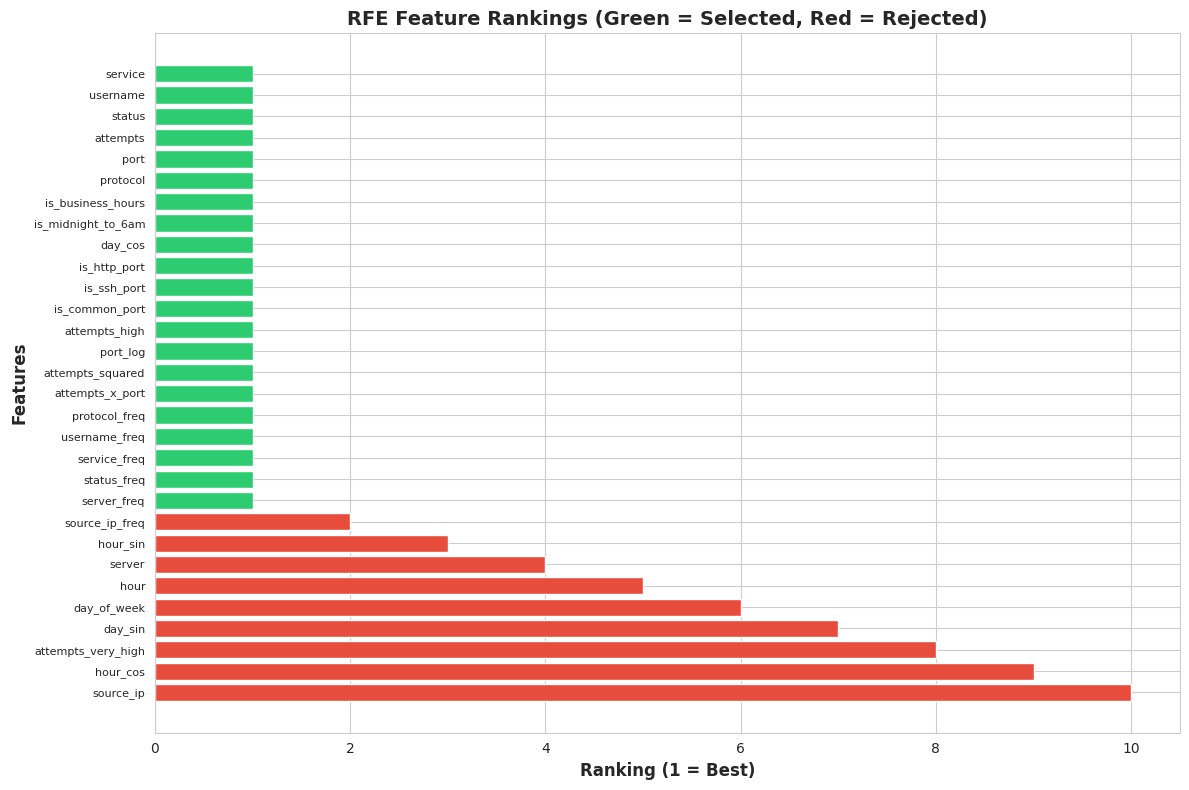

In [8]:
# Visualize feature rankings
feature_ranking = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': selector.ranking_,
    'Selected': selector.support_
}).sort_values('Ranking')

plt.figure(figsize=(12, 8))
colors = ['#2ecc71' if selected else '#e74c3c' for selected in feature_ranking['Selected']]
plt.barh(range(len(feature_ranking)), feature_ranking['Ranking'], color=colors)
plt.yticks(range(len(feature_ranking)), feature_ranking['Feature'], fontsize=8)
plt.xlabel('Ranking (1 = Best)', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('RFE Feature Rankings (Green = Selected, Red = Rejected)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# # 5. Dimensionality Reduction with TruncatedSVD


In [9]:
print("\n" + "="*80)
print("DIMENSIONALITY REDUCTION - TRUNCATED SVD")
print("="*80)

# TruncatedSVD is similar to PCA but works with sparse matrices
# Better for large datasets and doesn't center the data
n_components = min(12, X_train_selected.shape[1] - 1)  # Fixed number of components

svd = TruncatedSVD(n_components=n_components, random_state=42)
X_train_svd = svd.fit_transform(X_train_selected)
X_val_svd = svd.transform(X_val_selected)
X_test_svd = svd.transform(X_test_selected)

variance_explained = svd.explained_variance_ratio_.sum()

print(f"✓ TruncatedSVD applied")
print(f"✓ Original features: {X_train_selected.shape[1]}")
print(f"✓ SVD components: {n_components}")
print(f"✓ Variance explained: {variance_explained:.4f}")
print(f"✓ Final train shape: {X_train_svd.shape}")

# Save SVD
joblib.dump(svd, 'truncated_svd.pkl')
print("✓ SVD model saved as 'truncated_svd.pkl'")



DIMENSIONALITY REDUCTION - TRUNCATED SVD
✓ TruncatedSVD applied
✓ Original features: 21
✓ SVD components: 12
✓ Variance explained: 0.9997
✓ Final train shape: (350000, 12)
✓ SVD model saved as 'truncated_svd.pkl'


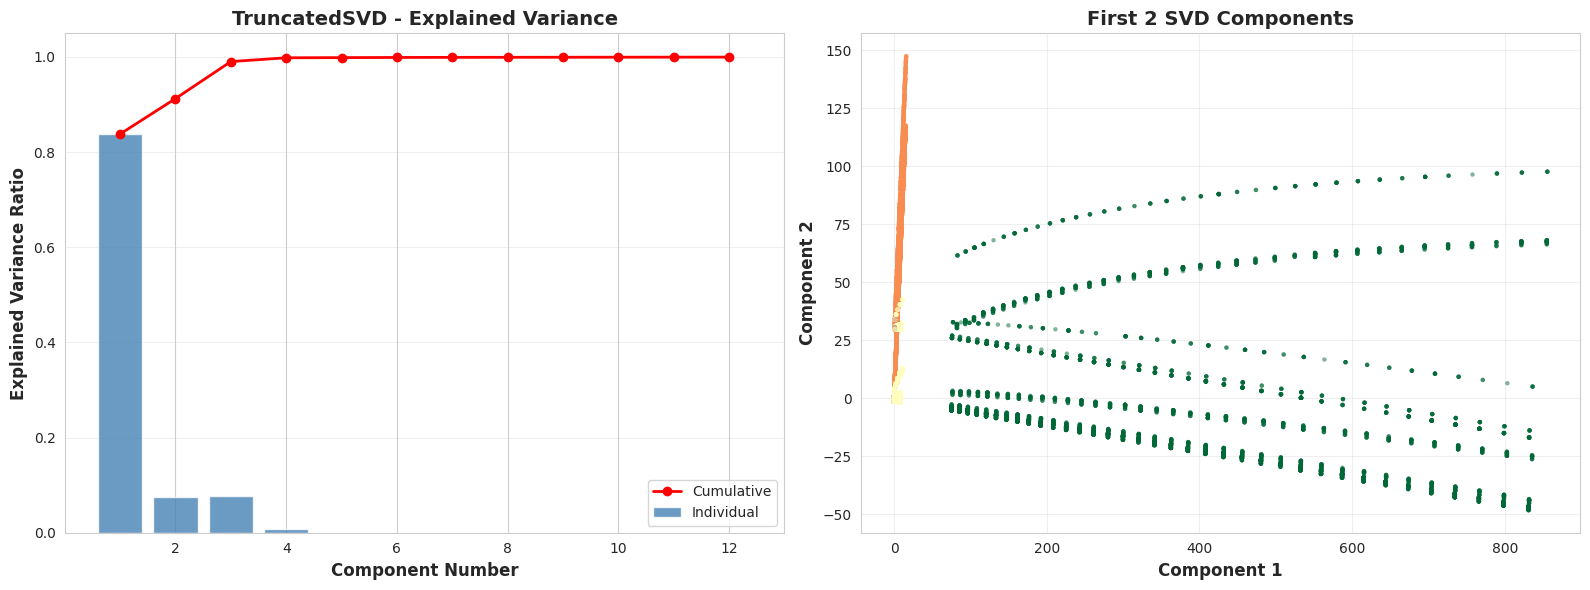

In [10]:
# Visualize SVD components
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Explained variance
axes[0].bar(range(1, len(svd.explained_variance_ratio_) + 1),
            svd.explained_variance_ratio_, color='steelblue', alpha=0.8)
axes[0].plot(range(1, len(svd.explained_variance_ratio_) + 1),
             np.cumsum(svd.explained_variance_ratio_), 'ro-', linewidth=2, markersize=6)
axes[0].set_xlabel('Component Number', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
axes[0].set_title('TruncatedSVD - Explained Variance', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].legend(['Cumulative', 'Individual'])

# Plot 2: First 2 components scatter
axes[1].scatter(X_train_svd[:, 0], X_train_svd[:, 1],
               c=y_train, cmap='RdYlGn_r', alpha=0.5, s=10, edgecolors='none')
axes[1].set_xlabel('Component 1', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Component 2', fontsize=12, fontweight='bold')
axes[1].set_title('First 2 SVD Components', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


# # 6. Kernel Approximation


In [11]:
print("\n" + "="*80)
print("KERNEL APPROXIMATION - RBF SAMPLER")
print("="*80)

# RBFSampler approximates RBF kernel feature map
# Allows linear models to approximate non-linear kernels
n_components_kernel = 100
rbf_sampler = RBFSampler(n_components=n_components_kernel, gamma=1.0, random_state=42)

X_train_kernel = rbf_sampler.fit_transform(X_train_svd)
X_val_kernel = rbf_sampler.transform(X_val_svd)
X_test_kernel = rbf_sampler.transform(X_test_svd)

print(f"✓ RBF Kernel Approximation applied")
print(f"✓ Input features: {X_train_svd.shape[1]}")
print(f"✓ Kernel features: {n_components_kernel}")
print(f"✓ Output shape: {X_train_kernel.shape}")
print(f"✓ This allows linear models to capture non-linear patterns!")

# Save RBF Sampler
joblib.dump(rbf_sampler, 'rbf_sampler.pkl')
print("✓ RBF Sampler saved as 'rbf_sampler.pkl'")



KERNEL APPROXIMATION - RBF SAMPLER
✓ RBF Kernel Approximation applied
✓ Input features: 12
✓ Kernel features: 100
✓ Output shape: (350000, 100)
✓ This allows linear models to capture non-linear patterns!
✓ RBF Sampler saved as 'rbf_sampler.pkl'


# # 7. Model Training and Validation


In [12]:
from xgboost import XGBClassifier

print("\n" + "="*80)
print("MODEL TRAINING")
print("="*80)

# Define models with kernel approximation support
models = {
    'Kernel Approximation (RBF + LogisticReg)': LogisticRegression(
        max_iter=1000, C=1.0, random_state=42, class_weight='balanced', n_jobs=-1
    ),
    'XGBoost Classifier': XGBClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, random_state=42, use_label_encoder=False, eval_metric='mlogloss'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=5,
        random_state=42, subsample=0.8
    )
}

# Store results
training_results = {}
validation_results = {}
trained_models = {}

print("\nTraining models on training data and validating on validation data...\n")

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print('='*60)

    # Use kernel features for Kernel Approximation, SVD features for others
    if 'Kernel Approximation' in model_name:
        X_tr, X_v, X_te = X_train_kernel, X_val_kernel, X_test_kernel
        print("Using: RBF Kernel Features")
    else:
        X_tr, X_v, X_te = X_train_svd, X_val_svd, X_test_svd
        print("Using: SVD Features")

    # Train the model
    model.fit(X_tr, y_train)
    print(f"✓ {model_name} training completed")

    # Predictions on training set
    y_train_pred = model.predict(X_tr)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)

    # Predictions on validation set
    y_val_pred = model.predict(X_v)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
    val_recall = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted', zero_division=0)

    # Store results
    training_results[model_name] = {
        'accuracy': train_accuracy,
        'precision': train_precision,
        'recall': train_recall,
        'f1_score': train_f1
    }

    validation_results[model_name] = {
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1_score': val_f1
    }

    trained_models[model_name] = {
        'model': model,
        'data_type': 'kernel' if 'Kernel Approximation' in model_name else 'svd'
    }

    # Print results
    print(f"\nTraining Set Performance:")
    print(f"  Accuracy:  {train_accuracy:.4f}")
    print(f"  Precision: {train_precision:.4f}")
    print(f"  Recall:    {train_recall:.4f}")
    print(f"  F1-Score:  {train_f1:.4f}")

    print(f"\nValidation Set Performance:")
    print(f"  Accuracy:  {val_accuracy:.4f}")
    print(f"  Precision: {val_precision:.4f}")
    print(f"  Recall:    {val_recall:.4f}")
    print(f"  F1-Score:  {val_f1:.4f}")

    # Check for overfitting
    overfit_score = train_accuracy - val_accuracy
    print(f"\nOverfitting Check: {overfit_score:.4f} (Train - Val Accuracy)")
    if overfit_score > 0.1:
        print("  Warning: Potential overfitting detected")
    else:
        print("  ✓ Model generalizes well")

print("\n" + "="*80)
print("ALL MODELS TRAINED SUCCESSFULLY")
print("="*80)



MODEL TRAINING

Training models on training data and validating on validation data...


Training: Kernel Approximation (RBF + LogisticReg)
Using: RBF Kernel Features
✓ Kernel Approximation (RBF + LogisticReg) training completed

Training Set Performance:
  Accuracy:  0.3850
  Precision: 0.9372
  Recall:    0.3850
  F1-Score:  0.5209

Validation Set Performance:
  Accuracy:  0.2535
  Precision: 0.9191
  Recall:    0.2535
  F1-Score:  0.3847

Overfitting Check: 0.1315 (Train - Val Accuracy)

Training: XGBoost Classifier
Using: SVD Features
✓ XGBoost Classifier training completed

Training Set Performance:
  Accuracy:  0.9753
  Precision: 0.9713
  Recall:    0.9753
  F1-Score:  0.9632

Validation Set Performance:
  Accuracy:  0.8671
  Precision: 0.9401
  Recall:    0.8671
  F1-Score:  0.8972

Overfitting Check: 0.1082 (Train - Val Accuracy)

Training: Gradient Boosting
Using: SVD Features
✓ Gradient Boosting training completed

Training Set Performance:
  Accuracy:  0.9767
  Precision: 0

In [13]:
# Create comparison dataframe
print("\n" + "="*80)
print("MODEL COMPARISON - TRAINING VS VALIDATION")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': list(models.keys()),
    'Train_Acc': [training_results[m]['accuracy'] for m in models.keys()],
    'Val_Acc': [validation_results[m]['accuracy'] for m in models.keys()],
    'Train_F1': [training_results[m]['f1_score'] for m in models.keys()],
    'Val_F1': [validation_results[m]['f1_score'] for m in models.keys()],
})

print("\n", comparison_df.to_string(index=False))



MODEL COMPARISON - TRAINING VS VALIDATION

                                    Model  Train_Acc  Val_Acc  Train_F1   Val_F1
Kernel Approximation (RBF + LogisticReg)   0.384997 0.253505  0.520878 0.384684
                      XGBoost Classifier   0.975326 0.867147  0.963216 0.897225
                       Gradient Boosting   0.976723 0.867387  0.966737 0.897381


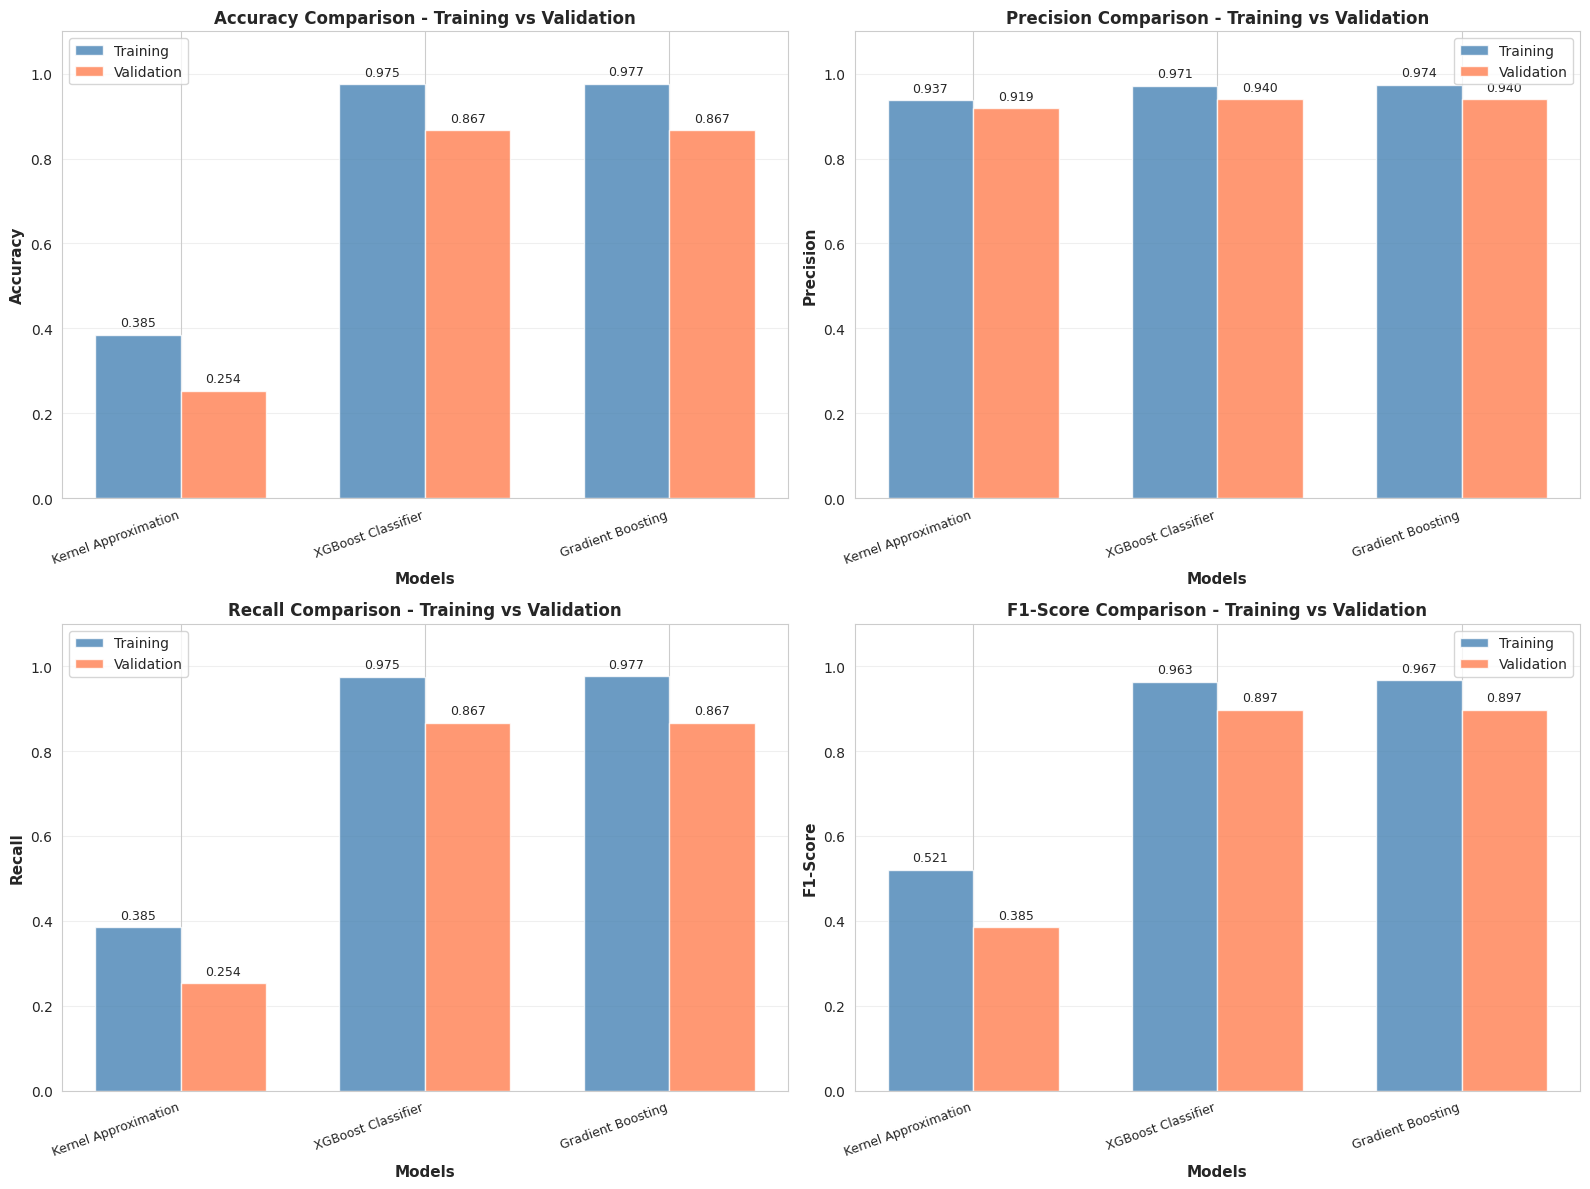

In [14]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['accuracy', 'precision', 'recall', 'f1_score']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx // 2, idx % 2]

    model_names = list(models.keys())
    train_scores = [training_results[m][metric] for m in model_names]
    val_scores = [validation_results[m][metric] for m in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    ax.bar(x - width/2, train_scores, width, label='Training', color='steelblue', alpha=0.8)
    ax.bar(x + width/2, val_scores, width, label='Validation', color='coral', alpha=0.8)

    ax.set_xlabel('Models', fontsize=11, fontweight='bold')
    ax.set_ylabel(metric_name, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric_name} Comparison - Training vs Validation', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([m.split('(')[0].strip() for m in model_names], rotation=20, ha='right', fontsize=9)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.1])

    # Add value labels
    for i, (train_val, val_val) in enumerate(zip(train_scores, val_scores)):
        ax.text(i - width/2, train_val + 0.02, f'{train_val:.3f}', ha='center', fontsize=9)
        ax.text(i + width/2, val_val + 0.02, f'{val_val:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()


# # 8. Save Trained Models


In [16]:
print("\n" + "="*80)
print("SAVING MODELS")
print("="*80)

# Save each trained model
model_filenames = {
    'Kernel Approximation (RBF + LogisticReg)': 'kernel_approximation_model.pkl',
    'XGBoost Classifier': 'xgboost_model.pkl',
    'Gradient Boosting': 'gradient_boosting_model.pkl'
}

for model_name, model_info in trained_models.items():
    filename = model_filenames[model_name]
    joblib.dump({
        'model': model_info['model'],
        'data_type': model_info['data_type']
    }, filename)
    print(f"✓ {model_name} saved as '{filename}'")

# Save the label encoder
joblib.dump(le_target, 'label_encoder_sedra.pkl')
print(f"✓ Label encoder saved as 'label_encoder_sedra.pkl'")

print("\n All models saved successfully!")



SAVING MODELS
✓ Kernel Approximation (RBF + LogisticReg) saved as 'kernel_approximation_model.pkl'
✓ XGBoost Classifier saved as 'xgboost_model.pkl'
✓ Gradient Boosting saved as 'gradient_boosting_model.pkl'
✓ Label encoder saved as 'label_encoder_sedra.pkl'

 All models saved successfully!


# # 9. Load Saved Models and Test on Test Data


In [17]:
print("\n" + "="*80)
print("LOADING SAVED MODELS")
print("="*80)

# Load models
loaded_models = {}
for model_name, filename in model_filenames.items():
    loaded_models[model_name] = joblib.load(filename)
    print(f"✓ Loaded {model_name} from '{filename}'")

# Load preprocessing objects
scaler_loaded = joblib.load('robust_scaler.pkl')
selector_loaded = joblib.load('rfe_selector.pkl')
svd_loaded = joblib.load('truncated_svd.pkl')
rbf_sampler_loaded = joblib.load('rbf_sampler.pkl')
le_target_loaded = joblib.load('label_encoder_sedra.pkl')

print("✓ Loaded all preprocessing objects")



LOADING SAVED MODELS
✓ Loaded Kernel Approximation (RBF + LogisticReg) from 'kernel_approximation_model.pkl'
✓ Loaded XGBoost Classifier from 'xgboost_model.pkl'
✓ Loaded Gradient Boosting from 'gradient_boosting_model.pkl'
✓ Loaded all preprocessing objects


# # 10. Test Models on Test Data


In [18]:
print("\n" + "="*80)
print("TESTING MODELS ON TEST DATA")
print("="*80)

test_results = {}

for model_name, model_info in loaded_models.items():
    print(f"\n{'='*60}")
    print(f"Testing: {model_name}")
    print('='*60)

    model = model_info['model']
    data_type = model_info['data_type']

    # Use appropriate features
    if data_type == 'kernel':
        X_te = X_test_kernel
        print("Using: RBF Kernel Features")
    else:
        X_te = X_test_svd
        print("Using: SVD Features")

    # Make predictions
    y_test_pred = model.predict(X_te)

    # Calculate metrics
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

    # Calculate AUC if model supports probability
    try:
        if hasattr(model, 'predict_proba'):
            y_test_proba = model.predict_proba(X_te)[:, 1]
            test_auc = roc_auc_score(y_test, y_test_proba)
        else:
            test_auc = None
    except:
        test_auc = None

    # Store results
    test_results[model_name] = {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': test_f1,
        'auc': test_auc,
        'predictions': y_test_pred
    }

    # Print results
    print(f"\nTest Set Performance:")
    print(f"  Accuracy:  {test_accuracy:.4f}")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall:    {test_recall:.4f}")
    print(f"  F1-Score:  {test_f1:.4f}")
    if test_auc is not None:
        print(f"  ROC-AUC:   {test_auc:.4f}")

    # Print classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test, y_test_pred,
                                target_names=le_target_loaded.classes_,
                                zero_division=0))

print("\n" + "="*80)
print("ALL MODELS TESTED SUCCESSFULLY")
print("="*80)



TESTING MODELS ON TEST DATA

Testing: Kernel Approximation (RBF + LogisticReg)
Using: RBF Kernel Features

Test Set Performance:
  Accuracy:  0.2631
  Precision: 0.9124
  Recall:    0.2631
  F1-Score:  0.3986

Detailed Classification Report:
                      precision    recall  f1-score   support

         brute_force       0.01      0.28      0.03      1247
         geo_anomaly       0.01      0.08      0.02      1225
              normal       0.96      0.27      0.42     95064
           port_scan       0.01      0.36      0.02      1225
privilege_escalation       0.00      0.00      0.00      1244

            accuracy                           0.26    100005
           macro avg       0.20      0.19      0.10    100005
        weighted avg       0.91      0.26      0.40    100005


Testing: XGBoost Classifier
Using: SVD Features

Test Set Performance:
  Accuracy:  0.8680
  Precision: 0.9408
  Recall:    0.8680
  F1-Score:  0.8980

Detailed Classification Report:
           

In [20]:
# Create final comparison table
print("\n" + "="*80)
print("FINAL MODEL COMPARISON - TRAIN / VALIDATION / TEST")
print("="*80)

final_comparison = pd.DataFrame({
    'Model': [m.split('(')[0].strip() for m in models.keys()],
    'Train_Acc': [training_results[m]['accuracy'] for m in models.keys()],
    'Val_Acc': [validation_results[m]['accuracy'] for m in models.keys()],
    'Test_Acc': [test_results[m]['accuracy'] for m in models.keys()],
    'Train_F1': [training_results[m]['f1_score'] for m in models.keys()],
    'Val_F1': [validation_results[m]['f1_score'] for m in models.keys()],
    'Test_F1': [test_results[m]['f1_score'] for m in models.keys()],
})

print("\n", final_comparison.to_string(index=False))

# Find best model
best_model_name = max(test_results.keys(), key=lambda x: test_results[x]['f1_score'])
print(f"\n Best Model (by Test F1-Score): {best_model_name}")
print(f"   Test Accuracy: {test_results[best_model_name]['accuracy']:.4f}")
print(f"   Test F1-Score: {test_results[best_model_name]['f1_score']:.4f}")
if test_results[best_model_name]['auc'] is not None:
    print(f"   Test ROC-AUC:  {test_results[best_model_name]['auc']:.4f}")



FINAL MODEL COMPARISON - TRAIN / VALIDATION / TEST

                Model  Train_Acc  Val_Acc  Test_Acc  Train_F1   Val_F1  Test_F1
Kernel Approximation   0.384997 0.253505  0.263107  0.520878 0.384684 0.398629
  XGBoost Classifier   0.975326 0.867147  0.868007  0.963216 0.897225 0.897990
   Gradient Boosting   0.976723 0.867387  0.868247  0.966737 0.897381 0.898147

 Best Model (by Test F1-Score): Gradient Boosting
   Test Accuracy: 0.8682
   Test F1-Score: 0.8981


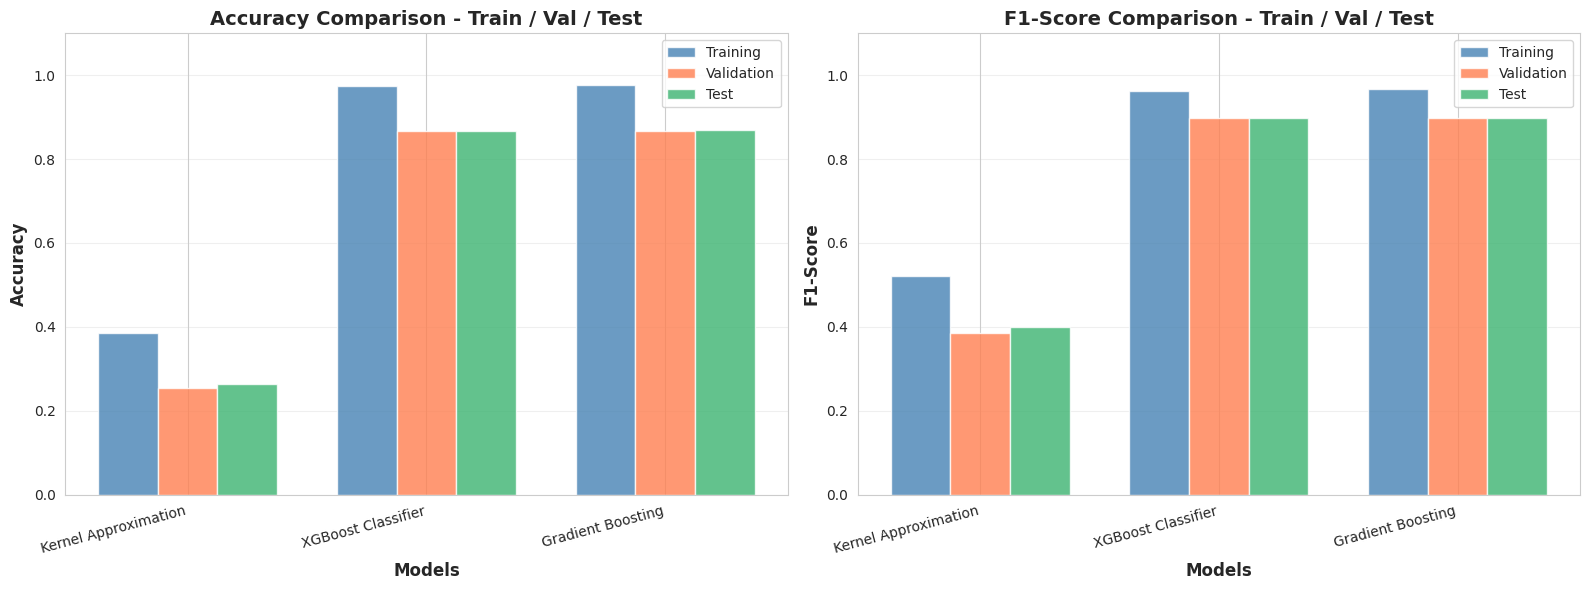

In [21]:
# Visualize final comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
ax1 = axes[0]
model_names_short = [m.split('(')[0].strip() for m in models.keys()]
train_acc = [training_results[m]['accuracy'] for m in models.keys()]
val_acc = [validation_results[m]['accuracy'] for m in models.keys()]
test_acc = [test_results[m]['accuracy'] for m in models.keys()]

x = np.arange(len(model_names_short))
width = 0.25

ax1.bar(x - width, train_acc, width, label='Training', color='steelblue', alpha=0.8)
ax1.bar(x, val_acc, width, label='Validation', color='coral', alpha=0.8)
ax1.bar(x + width, test_acc, width, label='Test', color='mediumseagreen', alpha=0.8)

ax1.set_xlabel('Models', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Accuracy Comparison - Train / Val / Test', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names_short, rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1.1])

# F1-Score comparison
ax2 = axes[1]
train_f1 = [training_results[m]['f1_score'] for m in models.keys()]
val_f1 = [validation_results[m]['f1_score'] for m in models.keys()]
test_f1 = [test_results[m]['f1_score'] for m in models.keys()]

ax2.bar(x - width, train_f1, width, label='Training', color='steelblue', alpha=0.8)
ax2.bar(x, val_f1, width, label='Validation', color='coral', alpha=0.8)
ax2.bar(x + width, test_f1, width, label='Test', color='mediumseagreen', alpha=0.8)

ax2.set_xlabel('Models', fontsize=12, fontweight='bold')
ax2.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax2.set_title('F1-Score Comparison - Train / Val / Test', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names_short, rotation=15, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()


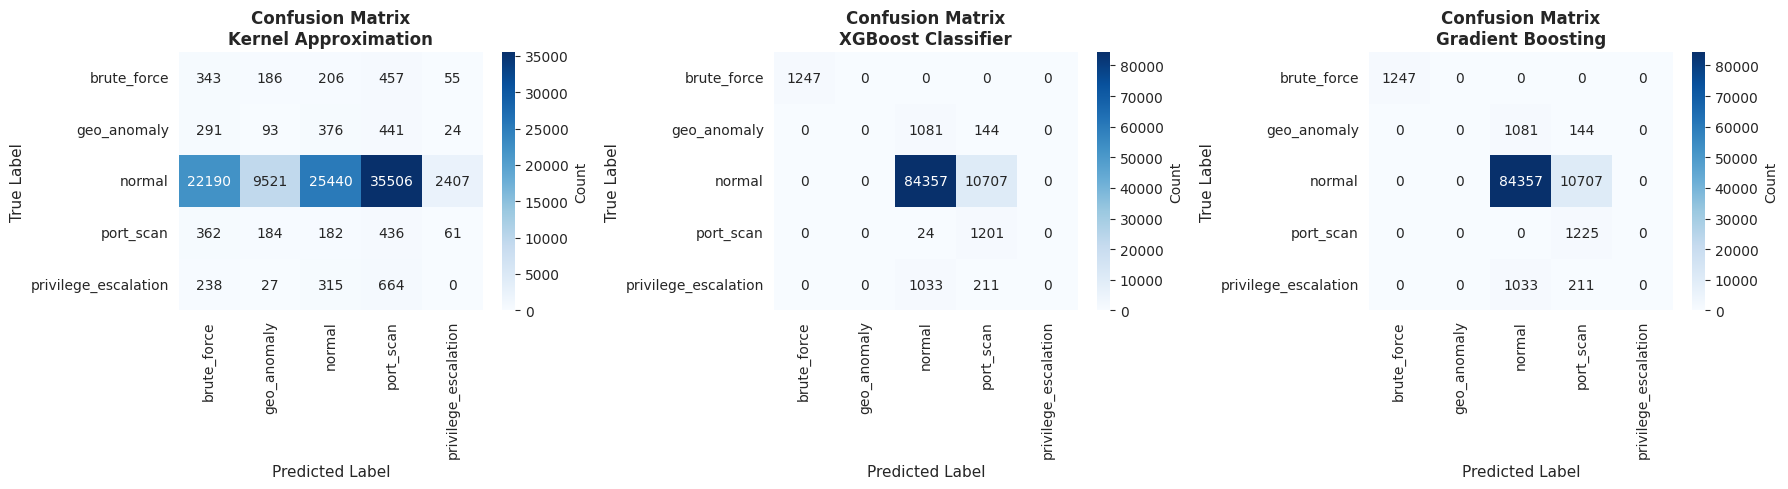

In [22]:
# Confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, model_info) in enumerate(loaded_models.items()):
    y_pred = test_results[model_name]['predictions']
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=le_target_loaded.classes_,
                yticklabels=le_target_loaded.classes_,
                cbar_kws={'label': 'Count'})

    model_short = model_name.split('(')[0].strip()
    axes[idx].set_title(f'Confusion Matrix\n{model_short}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11)
    axes[idx].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()


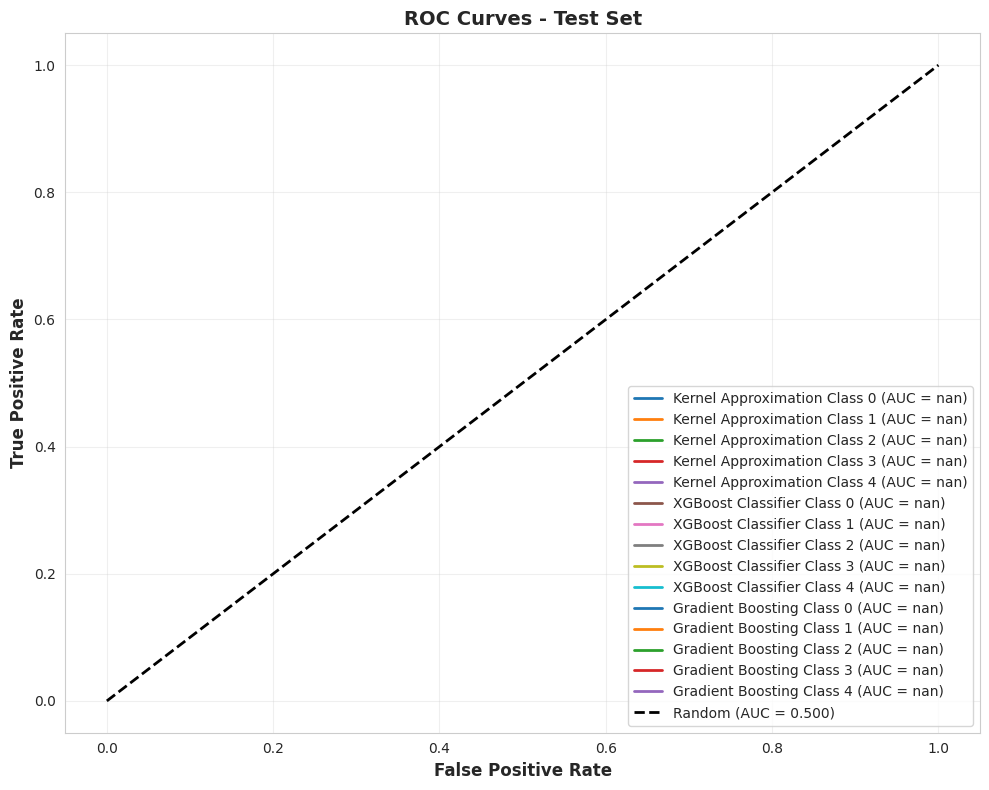

In [25]:
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=list(le_target.classes_))
n_classes = y_test_bin.shape[1]

fig, ax = plt.subplots(figsize=(10, 8))

for model_name, model_info in loaded_models.items():
    model = model_info['model']
    data_type = model_info['data_type']

    if hasattr(model, 'predict_proba'):
        X_te = X_test_kernel if data_type == 'kernel' else X_test_svd
        y_proba = model.predict_proba(X_te)

        # Plot ROC for each class
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
            roc_auc = auc(fpr, tpr)
            model_short = model_name.split('(')[0].strip()
            ax.plot(fpr, tpr, linewidth=2, label=f'{model_short} Class {i} (AUC = {roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC = 0.500)')
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves - Test Set', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# # 11. Final Summary


In [28]:
print("\n" + "="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

print("\n📊 Dataset Information:")
print(f"   - Training samples: {len(X_train)}")
print(f"   - Validation samples: {len(X_val)}")
print(f"   - Test samples: {len(X_test)}")
print(f"   - Original features: {train_data.shape[1] - 1}")
print(f"   - Engineered features: {X_train.shape[1]}")
print(f"   - Selected features (RFE): {X_train_selected.shape[1]}")
print(f"   - SVD components: {X_train_svd.shape[1]}")
print(f"   - Kernel features: {X_train_kernel.shape[1]}")

print("\n🔧 Advanced Preprocessing Pipeline ")
print("   ✓ Feature Engineering:")
print("      - Cyclic encoding (sin/cos) for time features")
print("      - Feature interactions (attempts × port)")
print("      - Frequency encoding for categoricals")
print("      - Port categorization features")
print("   ✓ RobustScaler (instead of StandardScaler)")
print("   ✓ RFE - Recursive Feature Elimination (instead of SelectKBest)")
print(f"   ✓ TruncatedSVD (instead of PCA) - {variance_explained:.2%} variance")
print(f"   ✓ RBF Kernel Approximation ({n_components_kernel} features)")

print("\n🤖 Models Trained:")
for model_name in models.keys():
    print(f"   ✓ {model_name}")

print("\n💾 Saved Files:")
print("   - robust_scaler.pkl")
print("   - rfe_selector.pkl")
print("   - truncated_svd.pkl")
print("   - rbf_sampler.pkl")
print("   - label_encoder_sedra.pkl")
print("   - kernel_approximation_model.pkl")
print("   - svc_model.pkl")
print("   - gradient_boosting_model.pkl")

print("\n Best Performing Model:")
print(f"   Model: {best_model_name}")
print(f"   Test Accuracy: {test_results[best_model_name]['accuracy']:.4f}")
print(f"   Test Precision: {test_results[best_model_name]['precision']:.4f}")
print(f"   Test Recall: {test_results[best_model_name]['recall']:.4f}")
print(f"   Test F1-Score: {test_results[best_model_name]['f1_score']:.4f}")
if test_results[best_model_name]['auc'] is not None:
    print(f"   Test ROC-AUC: {test_results[best_model_name]['auc']:.4f}")

print("\n" + "="*80)
print(" ADVANCED ML PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)



FINAL SUMMARY REPORT

📊 Dataset Information:
   - Training samples: 350000
   - Validation samples: 49995
   - Test samples: 100005
   - Original features: 10
   - Engineered features: 30
   - Selected features (RFE): 21
   - SVD components: 12
   - Kernel features: 100

🔧 Advanced Preprocessing Pipeline 
   ✓ Feature Engineering:
      - Cyclic encoding (sin/cos) for time features
      - Feature interactions (attempts × port)
      - Frequency encoding for categoricals
      - Port categorization features
   ✓ RobustScaler (instead of StandardScaler)
   ✓ RFE - Recursive Feature Elimination (instead of SelectKBest)
   ✓ TruncatedSVD (instead of PCA) - 99.97% variance
   ✓ RBF Kernel Approximation (100 features)

🤖 Models Trained:
   ✓ Kernel Approximation (RBF + LogisticReg)
   ✓ XGBoost Classifier
   ✓ Gradient Boosting

💾 Saved Files:
   - robust_scaler.pkl
   - rfe_selector.pkl
   - truncated_svd.pkl
   - rbf_sampler.pkl
   - label_encoder_sedra.pkl
   - kernel_approximation_mode